In [1]:
#!/home/was966/micromamba/envs/responder/bin/python
#sbatch --mem 64G -c 4 -t 100:00:00 -p gpu_quad --gres=gpu:rtx8000:1 ./loo_pft.py

import sys

sys.path.insert(0, '/home/was966/Research/mims-compass/')
from compass.utils import plot_embed_with_label
from compass import PreTrainer, FineTuner, loadcompass #, get_minmal_epoch
from compass.utils import plot_embed_with_label, plot_performance, score2
from compass.tokenizer import CANCER_CODE

import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")

def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

In [2]:
mfile = '../../checkpoint/latest/pretrainer.pt'
pretrainer = loadcompass(mfile, map_location = 'cpu')

data_path = '../../00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))

df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))[pretrainer.feature_name]
df_tpm.shape, df_label.shape

((1133, 15672), (1133, 110))

In [3]:
tmb_cohorts = ['IMVigor210', 'Rose', 'Liu',] #

In [4]:
df_label = df_label[~df_label.real_TMB.isna()]
df_label = df_label[df_label.real_TMB != 0]

df_label = df_label[df_label.cohort.isin(tmb_cohorts)]
df_label['log2_TMB'] = df_label.real_TMB # np.log(df_label.real_TMB + 1) #df_label.real_TMB #
df_tpm = df_tpm.loc[df_label.index]

In [5]:
size = df_label.groupby('cohort').size()
size = size.index + "\n(n = " + size.astype(str) + ")"

dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
cohorts = df_label.groupby('cohort').size().sort_values().index.tolist()
from sklearn.model_selection import LeaveOneOut

dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
dfy = df_label.response_label
dfg_score, dfc_score = pretrainer.extract(dfcx, batch_size=16)
dfc = dfc_score #[dfc_score.columns.difference(['Reference'])]

100%|##########| 27/27 [00:12<00:00,  2.18it/s]


In [6]:
df_tmb = dfc[['Genome_integrity']].join(df_label[['log2_TMB', 'cohort', 'cancer_type']]) 

In [7]:
df_tmb.head()

,Genome_integrity,log2_TMB,cohort,cancer_type
Index,,,,
IMVigor210-0257bb-ar-0257bbb,0.247796,18.0,IMVigor210,BLCA
IMVigor210-025b45-ar-025b45c,0.168329,1.0,IMVigor210,BLCA
IMVigor210-032c64-ar-032c642,0.293963,44.0,IMVigor210,BLCA
IMVigor210-0571f1-ar-0571f17,0.231509,2.0,IMVigor210,BLCA
IMVigor210-065890-ar-0658907,0.233928,8.0,IMVigor210,BLCA


In [8]:
df_tmb[['log2_TMB','Genome_integrity']].corr()

,log2_TMB,Genome_integrity
log2_TMB,1.000000,-0.128574
Genome_integrity,-0.128574,1.000000


In [9]:
size.index

Index(['IMVigor210', 'Liu', 'Rose'], dtype='object', name='cohort')

In [10]:
from compass.decoder import ProtoNetNFTDecoder,ClassDecoder
loo = LeaveOneOut()

In [11]:
dfco = dfc[dfc.columns.difference(['Genome_integrity'])]
dfts = dfco.join(dfc.Genome_integrity)
dftr = dfco.join(df_label.log2_TMB)
dftt = dfco.join(dfc.Genome_integrity).join(df_label.log2_TMB)

In [12]:
# dfts = (dfts - dfts.mean()) / (dfts.max() - dfts.min())
# dftr = (dftr - dftr.mean()) / (dftr.max() - dftr.min())
# dftt = (dftt - dftt.mean()) / (dftt.max() - dftt.min())

In [13]:
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegressionCV

In [24]:
res = []
for dfx_used, mode in zip([dfco, dfts, dftt], ['Pretrained concepts without\nGenome integrity (p=43)',
                                              'Pretrained concepts (p=44)', 
                                              'Pretrained concepts combine with\nTMB feature (p=45)', 
                                              ]): #'with_TMB_both\n(p=46)' , dftt

    print(dfx_used.shape)
    for cohort in tqdm(cohorts, ascii=True):
    
        cohort_idx = df_label[df_label['cohort'] == cohort].index
        cohort_X = dfx_used.loc[cohort_idx]
        cohort_y = dfy.loc[cohort_idx]
    
        test_cohort_name = cohort
    
        predict_res = []
        for train_idx, test_idx in loo.split(cohort_idx):
            
            train_X = cohort_X.iloc[train_idx]
            train_y = cohort_y.iloc[train_idx]
            test_X = cohort_X.iloc[test_idx]    
            test_y = cohort_y.iloc[test_idx]
        
            support_set = train_X.join(train_y)
            query_set = test_X.join(test_y)
            
            NFT = ProtoNetNFTDecoder()
            NFT = NFT.fit(support_set)
            pred_testy = NFT.transform(query_set)
            
            pred_testy['cohort'] = test_cohort_name
            pred_testy['mode'] = mode
            predict_res.append(pred_testy)
    
        df_pred = pd.concat(predict_res)
        dfp = onehot(cohort_y.map({'PD':'NR', 'PR':'R',
                                   'SD':'NR', 'CR':'R',
                                   'NR':'NR', 'R':'R'})).join(df_pred)
        
        y_true, y_prob, y_pred = dfp['R'], dfp[1], dfp[[0, 1]].idxmax(axis=1)
        s2 = score2(y_true, y_prob, y_pred)

        dfs = pd.DataFrame([s2], columns = ['ROC', 'PRC', 'F1', 'ACC', 'MCC'], index = ['Test'])
        dfs['cohort'] = test_cohort_name
        dfs['mode'] = mode
        res.append(dfs)

(427, 43)


100%|##########| 3/3 [00:02<00:00,  1.41it/s]


(427, 44)


100%|##########| 3/3 [00:02<00:00,  1.38it/s]


(427, 45)


100%|##########| 3/3 [00:02<00:00,  1.34it/s]


In [25]:
df = pd.concat(res).reset_index(drop=True)

In [26]:
df.cohort = df.cohort.map(size)

In [27]:
y_order = df.groupby('mode')['ACC'].mean().sort_values(ascending=False).index.tolist()
x_order = df.groupby('cohort')['ACC'].mean().sort_values(ascending=False).index.tolist()
x_order

['Rose\n(n = 87)', 'IMVigor210\n(n = 233)', 'Liu\n(n = 107)']

In [28]:
sns.palettes.color_palette('bright', 10)

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [29]:
c1 = sns.palettes.color_palette('Set2')[-1]
c2 = sns.palettes.color_palette('bright')[-1]
c3 = sns.palettes.color_palette('bright')[0]

In [30]:
palette = [c1, c2, c3]

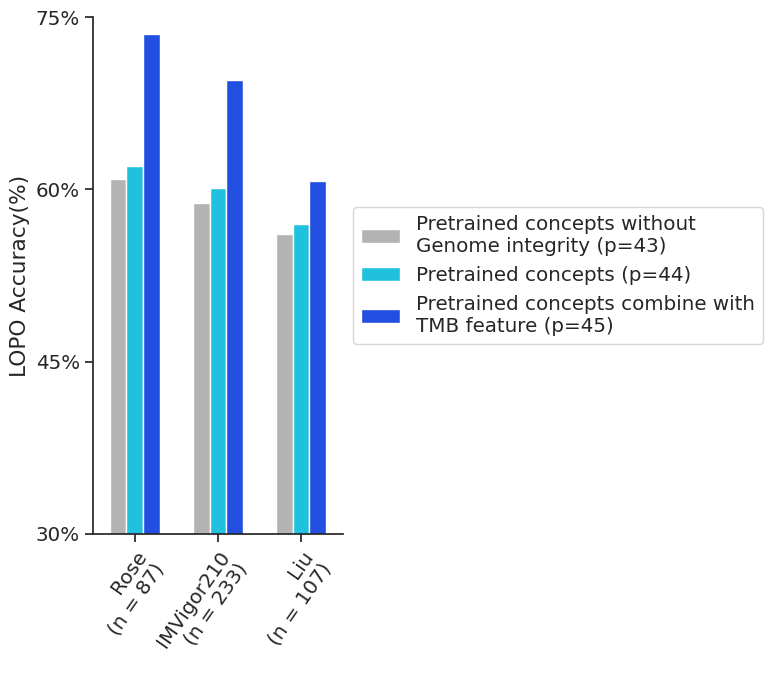

In [31]:
from matplotlib.ticker import MaxNLocator, FuncFormatter
fig, ax2 = plt.subplots(figsize=(8, 7), ncols=1)

axes = [ax2]


sns.barplot(data = df, x = 'cohort', y = 'ACC', width = 0.6, hue = 'mode' , ax=ax2,
            palette=palette,  order = x_order)
ax2.set_ylabel('LOPO Accuracy(%)')
ax2.set_ylim(0.3, 0.75)
ax2.yaxis.set_major_locator(MaxNLocator(nbins=3))
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax2.set_xlabel('')
# sns.barplot(data = df, x = 'cohort', y = 'PRC', width = 0.6,  hue = 'mode' , ax=ax1,
#             palette=palette,  order = x_order,)
# ax1.set_ylabel('LOPO PRC')
# ax1.set_ylim(0.15, 0.5)
# ax1.yaxis.set_major_locator(MaxNLocator(nbins=3))
# ax1.spines['right'].set_visible(False)
# ax1.spines['top'].set_visible(False)


for ax in axes:
    ax.tick_params(axis='both', which='major', right = False, top=False, 
                   direction = 'out',reset = True)
    
    ax.legend([],[], frameon = False)
    ax.set_xticklabels(x_order, 
                       rotation=55, 
                       ha="right",  
                       rotation_mode="anchor")  # <====== HERE is the ke

ax2.legend(bbox_to_anchor=(1.0, 0.5), loc = 'center left' , ncols =1)

fig.tight_layout()
fig.savefig('no_finetune_NFT_with_without_TMB.svg', bbox_inches = 'tight' )

In [32]:
df.to_csv('no_finetune_NFT_with_without_TMB.csv')